In [1]:
import sys
sys.path.append('./py/')

In [2]:
import ee
import folium
import json
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from google.cloud import storage
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
from osgeo import gdal
from osgeo import osr
from pprint import pprint

Using TensorFlow backend.


In [3]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "glodal_gee.json"
storage_client = storage.Client()

service_account = 'glodal-landcover-mapping@rohit-81.iam.gserviceaccount.com'
credentials = ee.ServiceAccountCredentials(service_account, 'glodal_gee.json')
ee.Initialize(credentials)

In [4]:
from Config import *
from ParamSelection import Landsat
from ProductSelection import Product
from IndicesAdd import Indices
from AssetsFilter import Assets

In [5]:
config = tf.ConfigProto()

config.gpu_options.allow_growth = True # dynamically grow the memory used on the GPU

config.log_device_placement = True

sess = tf.Session(config=config)

tf.keras.backend.set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2080 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



In [6]:
def reduce_class_value(feat):
    return feat.set('class', ee.Number(feat.get('class')).subtract(1))

In [7]:
ref_point = gtpt_asset.map(reduce_class_value)

In [8]:
for year in range(year_begin, year_end+1, 1):
    out_ext = ee.Geometry.Rectangle([ ROI['LonMin'], ROI['LatMin'], ROI['LonMax'], ROI['LatMax']])
    out_ext_center = out_ext.centroid()

    out_ext_buffer = out_ext.buffer(buffer_distance).bounds()

    center_lat = out_ext_center.getInfo()['coordinates'][1]
    center_lon = out_ext_center.getInfo()['coordinates'][0]
    
    landsat_parameters = Landsat(year_begin).select_landsat()
    
    gtYearBegin = year_begin
    gtYearEnd = year_end
    
    landsat_product = Product(landsat_parameters['Landsat'], gtYearBegin, gtYearEnd, ROI['doyFilterLandsat'], out_ext, cloud).select_product()
    
    LABEL_DATA = ref_point.filter(ee.Filter.And(ee.Filter.greaterThanOrEquals('year', gtYearBegin), ee.Filter.lessThanOrEquals('year', gtYearEnd), ROI['doyFilter']))
    LABEL_DATA = LABEL_DATA.filterBounds(landsat_product['region'])
    
    data_size = LABEL_DATA.size().getInfo()
    train_step = (data_size*0.8)//batch_size
    validate_step = (data_size*0.2)//batch_size
    
    Indices(landsat_parameters, landsat_product).add_indices()
    
    gt_image = landsat_product['image']
    gt_image_int = landsat_product['image_int']
    gt_image_texture = gt_image.addBands(gt_image_int.select(landsat_parameters['TextureBand']).entropy(kernel))

    out_image = landsat_product['image'].clip(out_ext_buffer)
    out_image_int = landsat_product['image_int'].clip(out_ext_buffer)
    out_image_texture = out_image.addBands(out_image_int.select(landsat_parameters['TextureBand']).entropy(kernel))

In [9]:
mapid = out_image_texture.getMapId({'bands': [landsat_parameters['FCCbands'][0], landsat_parameters['FCCbands'][1], landsat_parameters['FCCbands'][2]], 'min': 0, 'max': 0.3})
map = folium.Map(location=[center_lat, center_lon]) 
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='Out Image Texture',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

In [10]:
BANDS = landsat_parameters['bandsClassify']
FEATURE_NAMES = list(BANDS)
FEATURE_NAMES.append(LABEL)

In [11]:
sample = gt_image_texture.sampleRegions(
    collection = LABEL_DATA,
    properties = [LABEL],
    scale = spatial_resolution,
).randomColumn()

In [12]:
training = sample.filter(ee.Filter.lt('random', 0.8))
testing = sample.filter(ee.Filter.gte('random', 0.8))

# pprint({'training': training.first().getInfo()})
# pprint({'testing': testing.first().getInfo()})

In [13]:
training_task = ee.batch.Export.table.toCloudStorage(
    collection=training,
    description='Training Export',
    fileNamePrefix=TRAIN_FILE_PREFIX,
    bucket=OUTPUT_BUCKET,
    fileFormat='TFRecord',
    selectors=FEATURE_NAMES)

testing_task = ee.batch.Export.table.toCloudStorage(
    collection=testing,
    description='Testing Export',
    fileNamePrefix=TEST_FILE_PREFIX,
    bucket=OUTPUT_BUCKET,
    fileFormat='TFRecord',
    selectors=FEATURE_NAMES)

In [14]:
training_task.start()
testing_task.start()

In [15]:
while training_task.active():
    print('Polling for task (id: {}).'.format(training_task.id))
    time.sleep(10)
print('Done with training export.')

while testing_task.active():
    print('Polling for task (id: {}).'.format(testing_task.id))
    time.sleep(10)
print('Done with testing export.')

Polling for task (id: 3B6YM4CBPXB3TV5MH6SHXQ7C).
Polling for task (id: 3B6YM4CBPXB3TV5MH6SHXQ7C).
Polling for task (id: 3B6YM4CBPXB3TV5MH6SHXQ7C).
Polling for task (id: 3B6YM4CBPXB3TV5MH6SHXQ7C).
Polling for task (id: 3B6YM4CBPXB3TV5MH6SHXQ7C).
Polling for task (id: 3B6YM4CBPXB3TV5MH6SHXQ7C).
Polling for task (id: 3B6YM4CBPXB3TV5MH6SHXQ7C).
Polling for task (id: 3B6YM4CBPXB3TV5MH6SHXQ7C).
Polling for task (id: 3B6YM4CBPXB3TV5MH6SHXQ7C).
Done with training export.
Polling for task (id: VNRRSGVC2ID2CEKJ3FLMWV2X).
Done with testing export.


In [16]:
print('Found training file.' if tf.io.gfile.exists(TRAIN_FILE_PATH) 
    else 'No training file found.')
print('Found testing file.' if tf.io.gfile.exists(TEST_FILE_PATH) 
    else 'No testing file found.')

Found training file.
Found testing file.


In [17]:
train_dataset = tf.data.TFRecordDataset(TRAIN_FILE_PATH, compression_type='GZIP')
test_dataset = tf.data.TFRecordDataset(TEST_FILE_PATH, compression_type='GZIP')

# print(iter(train_dataset).next())
# print(iter(test_dataset).next())

In [18]:
columns = [
           tf.io.FixedLenFeature(shape=[1], dtype=tf.float32) for k in FEATURE_NAMES
]

features_dict = dict(zip(FEATURE_NAMES, columns))

# pprint(features_dict)

In [19]:
def parse_tfrecord(example_proto):
    parsed_features = tf.io.parse_single_example(example_proto, features_dict)
    labels = parsed_features.pop(LABEL)
    return parsed_features, tf.cast(labels, tf.int32)

parsed_trainset = train_dataset.map(parse_tfrecord, num_parallel_calls=5)
parsed_testset = test_dataset.map(parse_tfrecord, num_parallel_calls=5)

# pprint(iter(parsed_trainset))
# pprint(iter(parsed_testset))

In [20]:
def to_tuple(inputs, label):
    return (tf.transpose(list(inputs.values())), tf.one_hot(indices=label, depth=N_CLASSES))

input_dataset = parsed_trainset.map(to_tuple).batch(batch_size)
validate_dataset = parsed_testset.map(to_tuple).batch(batch_size)

In [21]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(N_CLASSES, activation=tf.nn.softmax)
])

In [22]:
model.compile(optimizer= tf.keras.optimizers.Adam(
    learning_rate=lr_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'mse']
)

In [23]:
def build_callbacks():
    checkpointer = ModelCheckpoint(filepath = MODEL_PATH + '/best_model.h5', monitor='val_acc', verbose=0, save_best_only=True)
    callbacks = [checkpointer]
    return callbacks
history = model.fit(x=input_dataset,
                    epochs=epochs,
                    callbacks=build_callbacks(),
                    validation_data=(validate_dataset),
                    validation_steps=validate_step,
                    shuffle=True
                    )

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on None steps, validate on 20.0 steps
Epoch 1/50
84/84 [==============================] - 3s 31ms/step - loss: 1.4234 - acc: 0.1829 - mean_squared_error: 0.1921 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.0000e+00
Epoch 2/50
84/84 [==============================] - 3s 34ms/step - loss: 1.3841 - acc: 0.3234 - mean_squared_error: 0.1872 - val_loss: 1.3319 - val_acc: 0.5785 - val_mean_squared_error: 0.1807
Epoch 3/50
84/84 [==============================] - 2s 29ms/step - loss: 1.3546 - acc: 0.3956 - mean_squared_error: 0.1836 - val_loss: 1.2853 - val_acc: 0.6730 - val_mean_squared_error: 0.1750
Epoch 4/50
84/84 [==============================] - 3s 37ms/step - loss: 1.3052 - acc: 0.4446 - mean_squared_error: 0.1777 - val_loss: 1.1955 - val_acc: 0.5980 - val_mean_squared_error: 0.1637
Epoch 5/50
84/84 [==============================] - 2s 28ms/step - loss: 1.2104 - acc: 0.47

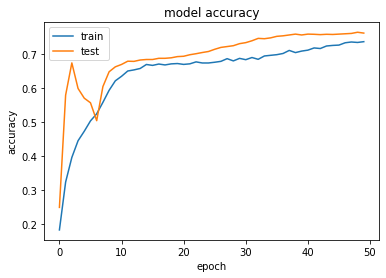

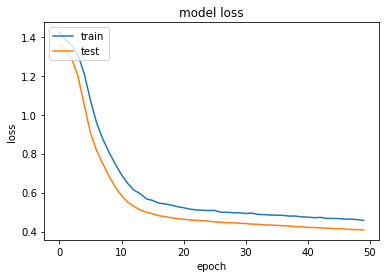

In [24]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
model.evaluate(validate_dataset, steps=None)

     22/Unknown - 1s 48ms/step - loss: 0.4257 - acc: 0.7729 - mean_squared_error: 0.0677

[0.42567757812040247, 0.7729401, 0.067743085]

In [26]:
image_export_options = {
    'patchDimensions': [patch_size, patch_size],
    'maxFileSize': 104857600,
    'compressed': True
}

image_task = ee.batch.Export.image.toCloudStorage(
    image=out_image_texture,
    description='Image Export',
    fileNamePrefix= INPUT_IMAGE_PREFIX,
    bucket=OUTPUT_BUCKET,
    scale=spatial_resolution,
    fileFormat='TFRecord',
    region=out_ext_buffer,
    formatOptions=image_export_options,
)

image_task.start()

In [27]:
while image_task.active():
    print('Polling for task (id: {}).'.format(image_task.id))
    time.sleep(10)
print('Done with image export.')

Polling for task (id: P3BEOTBDA7WCNM5YKSZEZF3N).
Polling for task (id: P3BEOTBDA7WCNM5YKSZEZF3N).
Polling for task (id: P3BEOTBDA7WCNM5YKSZEZF3N).
Polling for task (id: P3BEOTBDA7WCNM5YKSZEZF3N).
Polling for task (id: P3BEOTBDA7WCNM5YKSZEZF3N).
Polling for task (id: P3BEOTBDA7WCNM5YKSZEZF3N).
Done with image export.


In [28]:
fcc_image = out_image_texture.select(landsat_parameters['FCCbands'])

fcc_task = ee.batch.Export.image.toCloudStorage(
    image=fcc_image,
    description= 'FCC Image Export',
    fileNamePrefix=FCC_IMAGE_PREFIX,
    bucket=OUTPUT_BUCKET,
    scale=spatial_resolution,
    fileFormat='GeoTIFF',
    region=out_ext_buffer,
    formatOptions=image_export_options,
)

fcc_task.start()

In [29]:
while fcc_task.active():
    print('Polling for task (id: {}).'.format(fcc_task.id))
    time.sleep(10)
print('Done with FCC Image export.')

Polling for task (id: 3D7KQLKTXZ2HQM7S366WHVRF).
Polling for task (id: 3D7KQLKTXZ2HQM7S366WHVRF).
Polling for task (id: 3D7KQLKTXZ2HQM7S366WHVRF).
Polling for task (id: 3D7KQLKTXZ2HQM7S366WHVRF).
Done with FCC Image export.


In [30]:
fcc_name = FCC_IMAGE_PREFIX + '.tif'
fcc_output_file = FC_DIR + '/' +  IMAGE_FILE_PREFIX + '_fcc.tif'

bucket = storage_client.get_bucket('lc-mapping')
blob = bucket.blob(fcc_name)
with open(fcc_output_file, 'wb') as f:
    storage_client.download_blob_to_file(blob, f)

In [31]:
files_list = tf.io.gfile.listdir(INPUT_FILE_PATH)
exported_files_list = [s for s in files_list if IMAGE_FILE_PREFIX in s]

tfrecord_list = []
json_file = None
for f in exported_files_list:
    if f.endswith('.tfrecord.gz'):
        tfrecord_list.append(f)
    elif f.endswith('.json'):
        json_file = f
    
tfrecord_list.sort()

tfrecord_list = [INPUT_FILE_PATH + x for x in tfrecord_list]

print(tfrecord_list)
print(json_file)

['gs://lc-mapping/rohit/rohit_Chittagong_2020_2020_1623773271/inputs/Chittagong_2020_2020.tfrecord.gz']
Chittagong_2020_2020.json


In [32]:
file_name = USER_PATH + '/inputs/' + json_file
json_output_file = JSON_PATH + '/' + json_file

bucket = storage_client.get_bucket('lc-mapping')
blob = bucket.blob(file_name)
with open(json_output_file, 'wb') as f:
    storage_client.download_blob_to_file(blob, f)

In [33]:
with open(json_output_file, "r") as read_file:
    mixer = json.load(read_file)
mixer

{'projection': {'crs': 'EPSG:4326',
  'affine': {'doubleMatrix': [0.0010779783409434259,
    0.0,
    91.50526944932365,
    0.0,
    -0.0010779783409434259,
    22.63323324644817]}},
 'patchDimensions': [256, 256],
 'patchesPerRow': 2,
 'totalPatches': 4}

In [34]:
patch_width = mixer['patchDimensions'][0]
patch_height = mixer['patchDimensions'][1]
patches = mixer['totalPatches']
patch_dimensions_flat = [patch_width*patch_height, 1]

image_columns = [
                tf.io.FixedLenFeature(shape=patch_dimensions_flat, dtype=tf.float32) for k in BANDS
]

image_features_dict = dict(zip(BANDS, image_columns))

image_dataset = tf.data.TFRecordDataset(tfrecord_list, compression_type='GZIP')

In [35]:
def parse_image(example_proto):
    return tf.io.parse_single_example(example_proto, image_features_dict)

In [36]:
image_dataset = image_dataset.map(parse_image, num_parallel_calls=5)

image_dataset = image_dataset.flat_map(
    lambda features: tf.data.Dataset.from_tensor_slices(features)
)

image_dataset = image_dataset.map(
  lambda data_dict: (tf.transpose(list(data_dict.values())))
)

image_dataset = image_dataset.batch(patch_width * patch_height)

In [37]:
predictions = model.predict(image_dataset, steps=patches, verbose=1)
print(predictions[0])

4/4 [==============================] - 7s 2s/step
[[0.2022823  0.03026618 0.64349705 0.12395447]]


In [38]:
writer = tf.io.TFRecordWriter(OUTPUT_IMAGE_TFR)

patch = [[]]
cur_patch = 1
for prediction in predictions:
    patch[0].append(np.argmax(prediction))

    if (len(patch[0])==patch_width*patch_height):
        print('Done with Patch ' + str(cur_patch) + ' of ' + str(patches) + '...')
        example = tf.train.Example(
            features=tf.train.Features(
                feature={
                    'prediction': tf.train.Feature(
                        int64_list=tf.train.Int64List(
                            value=patch[0]
                        )
                    )
                }
            )
        )

        writer.write(example.SerializeToString())
        patch=[[]]
        cur_patch +=1
        
writer.close()

Done with Patch 1 of 4...
Done with Patch 2 of 4...
Done with Patch 3 of 4...
Done with Patch 4 of 4...


In [39]:
record_iterator = tf.compat.v1.python_io.tf_record_iterator(path=OUTPUT_IMAGE_TFR)

n_row = patches/mixer['patchesPerRow']
n_col = mixer['patchesPerRow']
current_row = 0
current_col = 0
counter = 0

for string_record in record_iterator:
    example = tf.train.Example()
    example.ParseFromString(string_record)
    values = np.array(example.features.feature['prediction'].int64_list.value).reshape(patch_width, patch_height).astype(np.int8)

    if (current_col==0):
        horizontal_strip = values
    else:
        horizontal_strip = np.concatenate([horizontal_strip, values], axis=1)
    current_col += 1

    if (current_col == n_col):
        if (current_row==0):
            image = horizontal_strip
        else:
            image = np.concatenate([image, horizontal_strip], axis=0)
            horizontal_strip = []

        current_row +=1
        current_col = 0
        print(counter)
    counter +=1
print(counter)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
1
3
4


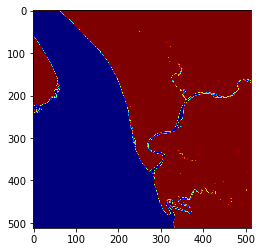

In [40]:
imgplot = plt.imshow(image, cmap=plt.get_cmap('jet'), vmin=0, vmax=1)
plt.show()

In [41]:
affine = mixer['projection']['affine']['doubleMatrix']
geotransform = (affine[2], affine[0], affine[1], affine[5], affine[3], affine[4])
crs = int(mixer['projection']['crs'][-4:])
print(affine)
print(geotransform)
print(crs)

[0.0010779783409434259, 0.0, 91.50526944932365, 0.0, -0.0010779783409434259, 22.63323324644817]
(91.50526944932365, 0.0010779783409434259, 0.0, 22.63323324644817, 0.0, -0.0010779783409434259)
4326


In [42]:
ny, nx = image.shape
dst_ds = gdal.GetDriverByName('GTiff').Create(LC_IMAGE_TIF, nx, ny, 1, gdal.GDT_Byte)
dst_ds.SetGeoTransform(tuple(geotransform))
srs = osr.SpatialReference()
srs.ImportFromEPSG(crs)
dst_ds.SetProjection(srs.ExportToWkt())
dst_ds.GetRasterBand(1).WriteArray(image)
dst_ds.FlushCache()
dst_ds = None

print("Exorting " + LC_IMAGE_TIF + " completed.")

Exorting ./rohit/rohit_Chittagong_2020_2020_1623773271/lc-map/Chittagong_2020_2020.tif completed.
